In [144]:
#!sudo apt-get install xvfb

#!pip install gym[classic_control]

In [145]:
#!pip install gym-notebook-wrapper

In [146]:
import gnwrapper

In [147]:
#Importing libraries
import gym
from collections import namedtuple
import numpy as np
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim


In [148]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70


In [149]:
#Creating the nn Class
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)


In [150]:
#Using name tupple
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

In [151]:
#Use to iterate batches
def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs = env.reset()      # Reseting the environment to get the current state of the environment
    sm = nn.Softmax(dim=1) # Pass it a softmax activation function with dimention of 1
    while True:
        obs_v = torch.FloatTensor([obs])  # Change the current state to tensor float of 1 x4 since the enironment have 4 environment space
        act_probs_v = sm(net(obs_v))      # This returns tensors that tracks Gradient
        act_probs = act_probs_v.data.numpy()[0] # We use this to unpack the tensor and only return the first dimension [0] using the .data
                                                # and then converting it to numpy array
        action = np.random.choice(len(act_probs), p=act_probs) # The action is take by using numpy sampling choice base on the return obs space value
        next_obs, reward, is_done, _ = env.step(action)       # Take the action and return the current state of the environment
        episode_reward += reward
        step = EpisodeStep(observation=obs, action=action)  # assign the environment gotten from line 5 to the name tuple which is as a list or class
        episode_steps.append(step)                        # append the step to eppisode_steps
        if is_done:
            e = Episode(reward=episode_reward, steps=episode_steps) # if the game is done assign the episode reward and action the the episode name tuple
            batch.append(e)                                   # append the result to the batch
            episode_reward = 0.0                              # clear the the episode reward
            episode_steps = []                                # Clear the episode step
            next_obs = env.reset()                            # Reset the environment for new state
            if len(batch) == batch_size:                      # If The game is finish
                yield batch                                   #Yield return contro to the caller
                batch = []                                    #Clear the batch
        obs = next_obs                                      # assigned the environment we got from  line 13


In [152]:
#filter batches

def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))  # map the batch to the lamda function and return only the reward
    reward_bound = np.percentile(rewards, percentile) # calculate the array of the reward as for 70 percentile reward bound
    reward_mean = float(np.mean(rewards))            # calculate the mean of the reward and convert it to numpy array

    train_obs = []
    train_act = []
    for reward, steps in batch:        
        if reward < reward_bound:                   # If reward is below 70 percentile
            continue                                # continue
        train_obs.extend(map(lambda step: step.observation, steps))  # Return observation using map function
        train_act.extend(map(lambda step: step.action, steps))        # return action 

    train_obs_v = torch.FloatTensor(train_obs)               #Convert the train observation to tensor float
    train_act_v = torch.LongTensor(train_act)               # convert action to to tensor Long
    return train_obs_v, train_act_v, reward_bound, reward_mean

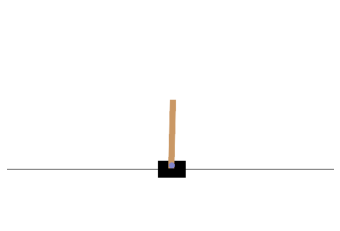

45: loss=0.570, reward_mean=308.9, rw_bound=349.0
Solved!


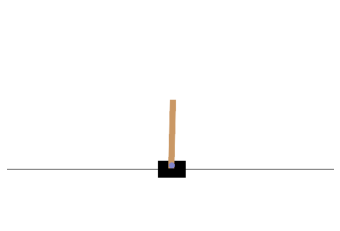

In [154]:
if __name__ == "__main__":
    #env = gym.make("CartPole-v0")
    env = gnwrapper.Animation(gym.make('CartPole-v1'))     #Make the Environment
    #env = gym.wrappers.Monitor(env, directory="mon", force=True)
    obs_size = env.observation_space.shape[0]   # here we return the environment size
    n_actions = env.action_space.n              # This returns the number of possible action in a gym env observation

    net = Net(obs_size, HIDDEN_SIZE, n_actions)   # We apply our net Class here with obs_size=4, n_ction= 2
    objective = nn.CrossEntropyLoss()             # We use our cross entropy loss optimixer to reduce the error
    optimizer = optim.Adam(params=net.parameters(), lr=0.01) #We use adam as the optimizer
    writer = SummaryWriter(comment="-cartpole")         # For tensor board

    for iter_no, batch in enumerate(iterate_batches(
            env, net, BATCH_SIZE)):
        obs_v, acts_v, reward_b, reward_m = \
            filter_batch(batch, PERCENTILE)
        optimizer.zero_grad()
        action_scores_v = net(obs_v)
        loss_v = objective(action_scores_v, acts_v)
        loss_v.backward()
        optimizer.step()
        env.render()
        print("%d: loss=%.3f, reward_mean=%.1f, rw_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
        writer.add_scalar("loss", loss_v.item(), iter_no)
        writer.add_scalar("reward_bound", reward_b, iter_no)
        writer.add_scalar("reward_mean", reward_m, iter_no)
        if reward_m > 300:
            print("Solved!")
            break
    writer.close()
    env.close()
